### val data 추가.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
import statsmodels.formula.api as smf
import shutil

In [2]:
%load_ext tensorboard

In [3]:
train_raw_dataset = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/dacon_basic_irisdataset/iris_train.csv")
test_raw_dataset = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/dacon_basic_irisdataset/iris_test.csv")
test_raw_dataset.shape

(75, 4)

In [4]:
test_raw_dataset.head()

,id,species,sepal length (cm),petal length (cm)
0,0,setosa,5.4,1.7
1,1,setosa,5.7,1.5
2,2,setosa,5.3,1.5
3,3,setosa,5.1,1.9
4,4,virginica,6.0,4.8


In [5]:
test_raw_dataset.species.value_counts()

setosa        35
virginica     20
versicolor    20
Name: species, dtype: int64

In [6]:
test_raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 75 non-null     int64  
 1   species            75 non-null     object 
 2   sepal length (cm)  75 non-null     float64
 3   petal length (cm)  75 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ KB


In [7]:
test_raw_dataset.isnull().sum()

id                   0
species              0
sepal length (cm)    0
petal length (cm)    0
dtype: int64

In [8]:
train_raw_dataset = train_raw_dataset.drop("id", axis=1)
test_raw_dataset = test_raw_dataset.drop("id", axis=1)
train_raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            75 non-null     object 
 1   sepal length (cm)  75 non-null     float64
 2   petal length (cm)  75 non-null     float64
 3   sepal width (cm)   75 non-null     float64
 4   petal width (cm)   75 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.1+ KB


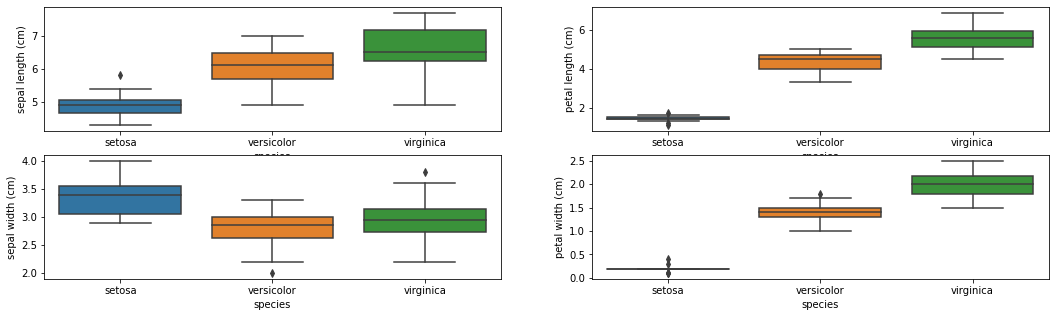

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(18, 5))
col = ['sepal length (cm)', 'petal length (cm)', 'sepal width (cm)',
       'petal width (cm)']

for idx, name in enumerate(col):
    i = idx // 2
    j = idx % 2
    sns.boxplot(x="species", y=name, data=train_raw_dataset, ax=ax[i][j])

# 실험해 본다면 sepal length 와 width의 outlier를 제거하는 것은 어떨까? - 오히려 더 떨어짐.

In [11]:
# 라벨 구분
LABEL = ['sepal width (cm)', 'petal width (cm)']
X_train = train_raw_dataset.copy()
X_train = X_train.drop(LABEL, axis=1)
y_train = train_raw_dataset[LABEL]
y_train.head()

# X_train, y_train = train_raw_dataset[0~1:1~2] 이런식으로 하는 방법은 없을까?




,sepal width (cm),petal width (cm)
0,2.9,0.2
1,3.2,1.5
2,2.8,1.8
3,3.6,2.5
4,3.0,0.2


In [12]:
# 범주형 데이터 species 처리
col = X_train["species"].unique()
species_col = {'setosa': 1, 'versicolor': 2, 'virginica': 3}
X_train["species"] = X_train.species.map(species_col)
test_raw_dataset["species"] = test_raw_dataset["species"].map(species_col)
X_train.head()
test_raw_dataset.head()

# map 말고 apply로 적용해보는 것은 어떨까?

,species,sepal length (cm),petal length (cm)
0,1,5.4,1.7
1,1,5.7,1.5
2,1,5.3,1.5
3,1,5.1,1.9
4,3,6.0,4.8


In [13]:
# val 데이터 만들기. 8:2
# train_dataset, val_dataset = np.split(train_raw_dataset, [int(len(train_raw_dataset)*0.8)])

In [14]:
## input 데이터 만들기
# inputs = {col_name : keras.Input(name=col_name, shape=(), dtype="float32") for col_name in col_names}
input_dim = X_train.shape[1]
inputs = keras.layers.Input(shape=(input_dim, ))

# tf.dataset 형식으로 만들어보는 것은 어떨까?

In [61]:
# 모델 만들기, custom lossfunction 만들기
l2learning_rate = 0.0000001
    

def build_model(inputs):
    layers = keras.layers.Dense(36, activation="tanh", activity_regularizer=keras.regularizers.l2(l2learning_rate))(inputs)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    
    layers = keras.layers.Dense(18, activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    
    layers = keras.layers.Dense(9, activation="tanh")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    
    layers = keras.layers.Dense(4, activation="relu")(layers)
    
    output_sw = keras.layers.Dense(1, name="prd_sepal_width")(layers)
    output_pw = keras.layers.Dense(1, name="prd_petal_width")(layers)
    outputs = [output_sw, output_pw]
    
    model = keras.models.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    # optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mae", metrics=["mae"])
    return model

# sub class 형식으로 만들어보는 것은 어떨까?

In [62]:
model = build_model(inputs)

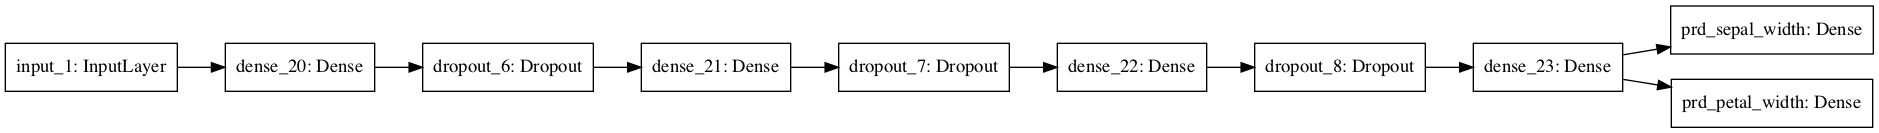

In [63]:
keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

In [64]:
y_train.head()
OUTDIR = "./iris_train"
shutil.rmtree(path=OUTDIR, ignore_errors=True)

history = model.fit(x=X_train, y={"prd_sepal_width" : y_train["sepal width (cm)"], 
                                 "prd_petal_width" : y_train["petal width (cm)"]},
                   epochs=1000,
                   batch_size=3,
                   verbose=1,
                   validation_split=0.2,
                   callbacks=[TensorBoard(OUTDIR)])

Epoch 1/1000
20/20 [==============================] - 1s 16ms/step - loss: 4.7633 - prd_sepal_width_loss: 3.1136 - prd_petal_width_loss: 1.6497 - prd_sepal_width_mae: 3.1136 - prd_petal_width_mae: 1.6497 - val_loss: 4.3256 - val_prd_sepal_width_loss: 2.8061 - val_prd_petal_width_loss: 1.5194 - val_prd_sepal_width_mae: 2.8061 - val_prd_petal_width_mae: 1.5194
Epoch 2/1000
20/20 [==============================] - 0s 4ms/step - loss: 4.4271 - prd_sepal_width_loss: 3.0160 - prd_petal_width_loss: 1.4110 - prd_sepal_width_mae: 3.0160 - prd_petal_width_mae: 1.4110 - val_loss: 4.2704 - val_prd_sepal_width_loss: 2.7855 - val_prd_petal_width_loss: 1.4849 - val_prd_sepal_width_mae: 2.7855 - val_prd_petal_width_mae: 1.4849
Epoch 3/1000
20/20 [==============================] - 0s 3ms/step - loss: 4.2503 - prd_sepal_width_loss: 2.9392 - prd_petal_width_loss: 1.3110 - prd_sepal_width_mae: 2.9392 - prd_petal_width_mae: 1.3110 - val_loss: 4.2141 - val_prd_sepal_width_loss: 2.7666 - val_prd_petal_width_

Epoch 24/1000
20/20 [==============================] - 0s 2ms/step - loss: 1.0909 - prd_sepal_width_loss: 0.5768 - prd_petal_width_loss: 0.5141 - prd_sepal_width_mae: 0.5768 - prd_petal_width_mae: 0.5141 - val_loss: 0.5552 - val_prd_sepal_width_loss: 0.2502 - val_prd_petal_width_loss: 0.3051 - val_prd_sepal_width_mae: 0.2502 - val_prd_petal_width_mae: 0.3051
Epoch 25/1000
20/20 [==============================] - 0s 2ms/step - loss: 1.0266 - prd_sepal_width_loss: 0.5654 - prd_petal_width_loss: 0.4612 - prd_sepal_width_mae: 0.5654 - prd_petal_width_mae: 0.4612 - val_loss: 0.5353 - val_prd_sepal_width_loss: 0.2481 - val_prd_petal_width_loss: 0.2872 - val_prd_sepal_width_mae: 0.2481 - val_prd_petal_width_mae: 0.2872
Epoch 26/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.9333 - prd_sepal_width_loss: 0.4620 - prd_petal_width_loss: 0.4714 - prd_sepal_width_mae: 0.4620 - prd_petal_width_mae: 0.4714 - val_loss: 0.5096 - val_prd_sepal_width_loss: 0.2410 - val_prd_petal_widt

Epoch 47/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.8428 - prd_sepal_width_loss: 0.4713 - prd_petal_width_loss: 0.3715 - prd_sepal_width_mae: 0.4713 - prd_petal_width_mae: 0.3715 - val_loss: 0.4248 - val_prd_sepal_width_loss: 0.2305 - val_prd_petal_width_loss: 0.1943 - val_prd_sepal_width_mae: 0.2305 - val_prd_petal_width_mae: 0.1943
Epoch 48/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.9028 - prd_sepal_width_loss: 0.5512 - prd_petal_width_loss: 0.3516 - prd_sepal_width_mae: 0.5512 - prd_petal_width_mae: 0.3516 - val_loss: 0.4402 - val_prd_sepal_width_loss: 0.2401 - val_prd_petal_width_loss: 0.2002 - val_prd_sepal_width_mae: 0.2401 - val_prd_petal_width_mae: 0.2002
Epoch 49/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.9015 - prd_sepal_width_loss: 0.5159 - prd_petal_width_loss: 0.3856 - prd_sepal_width_mae: 0.5159 - prd_petal_width_mae: 0.3856 - val_loss: 0.4540 - val_prd_sepal_width_loss: 0.2446 - val_prd_petal_widt

Epoch 70/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.7421 - prd_sepal_width_loss: 0.4071 - prd_petal_width_loss: 0.3350 - prd_sepal_width_mae: 0.4071 - prd_petal_width_mae: 0.3350 - val_loss: 0.3950 - val_prd_sepal_width_loss: 0.2542 - val_prd_petal_width_loss: 0.1408 - val_prd_sepal_width_mae: 0.2542 - val_prd_petal_width_mae: 0.1408
Epoch 71/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.8770 - prd_sepal_width_loss: 0.5361 - prd_petal_width_loss: 0.3409 - prd_sepal_width_mae: 0.5361 - prd_petal_width_mae: 0.3409 - val_loss: 0.4525 - val_prd_sepal_width_loss: 0.2411 - val_prd_petal_width_loss: 0.2114 - val_prd_sepal_width_mae: 0.2411 - val_prd_petal_width_mae: 0.2114
Epoch 72/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.8229 - prd_sepal_width_loss: 0.4762 - prd_petal_width_loss: 0.3468 - prd_sepal_width_mae: 0.4762 - prd_petal_width_mae: 0.3468 - val_loss: 0.3925 - val_prd_sepal_width_loss: 0.2458 - val_prd_petal_widt

Epoch 93/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.7951 - prd_sepal_width_loss: 0.4608 - prd_petal_width_loss: 0.3343 - prd_sepal_width_mae: 0.4608 - prd_petal_width_mae: 0.3343 - val_loss: 0.4045 - val_prd_sepal_width_loss: 0.2425 - val_prd_petal_width_loss: 0.1620 - val_prd_sepal_width_mae: 0.2425 - val_prd_petal_width_mae: 0.1620
Epoch 94/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.7677 - prd_sepal_width_loss: 0.4168 - prd_petal_width_loss: 0.3509 - prd_sepal_width_mae: 0.4168 - prd_petal_width_mae: 0.3509 - val_loss: 0.4088 - val_prd_sepal_width_loss: 0.2327 - val_prd_petal_width_loss: 0.1761 - val_prd_sepal_width_mae: 0.2327 - val_prd_petal_width_mae: 0.1761
Epoch 95/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6254 - prd_sepal_width_loss: 0.3387 - prd_petal_width_loss: 0.2867 - prd_sepal_width_mae: 0.3387 - prd_petal_width_mae: 0.2867 - val_loss: 0.4036 - val_prd_sepal_width_loss: 0.2393 - val_prd_petal_widt

Epoch 116/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.7367 - prd_sepal_width_loss: 0.4257 - prd_petal_width_loss: 0.3109 - prd_sepal_width_mae: 0.4257 - prd_petal_width_mae: 0.3109 - val_loss: 0.3888 - val_prd_sepal_width_loss: 0.2320 - val_prd_petal_width_loss: 0.1569 - val_prd_sepal_width_mae: 0.2320 - val_prd_petal_width_mae: 0.1569
Epoch 117/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6769 - prd_sepal_width_loss: 0.4128 - prd_petal_width_loss: 0.2641 - prd_sepal_width_mae: 0.4128 - prd_petal_width_mae: 0.2641 - val_loss: 0.4015 - val_prd_sepal_width_loss: 0.2367 - val_prd_petal_width_loss: 0.1649 - val_prd_sepal_width_mae: 0.2367 - val_prd_petal_width_mae: 0.1649
Epoch 118/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.7122 - prd_sepal_width_loss: 0.3975 - prd_petal_width_loss: 0.3147 - prd_sepal_width_mae: 0.3975 - prd_petal_width_mae: 0.3147 - val_loss: 0.3985 - val_prd_sepal_width_loss: 0.2428 - val_prd_petal_w

Epoch 139/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6487 - prd_sepal_width_loss: 0.3534 - prd_petal_width_loss: 0.2953 - prd_sepal_width_mae: 0.3534 - prd_petal_width_mae: 0.2953 - val_loss: 0.3474 - val_prd_sepal_width_loss: 0.2248 - val_prd_petal_width_loss: 0.1226 - val_prd_sepal_width_mae: 0.2248 - val_prd_petal_width_mae: 0.1226
Epoch 140/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6743 - prd_sepal_width_loss: 0.3775 - prd_petal_width_loss: 0.2968 - prd_sepal_width_mae: 0.3775 - prd_petal_width_mae: 0.2968 - val_loss: 0.3491 - val_prd_sepal_width_loss: 0.2229 - val_prd_petal_width_loss: 0.1262 - val_prd_sepal_width_mae: 0.2229 - val_prd_petal_width_mae: 0.1262
Epoch 141/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6807 - prd_sepal_width_loss: 0.3939 - prd_petal_width_loss: 0.2867 - prd_sepal_width_mae: 0.3939 - prd_petal_width_mae: 0.2867 - val_loss: 0.3696 - val_prd_sepal_width_loss: 0.2171 - val_prd_petal_w

Epoch 162/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6379 - prd_sepal_width_loss: 0.3662 - prd_petal_width_loss: 0.2717 - prd_sepal_width_mae: 0.3662 - prd_petal_width_mae: 0.2717 - val_loss: 0.3774 - val_prd_sepal_width_loss: 0.2362 - val_prd_petal_width_loss: 0.1412 - val_prd_sepal_width_mae: 0.2362 - val_prd_petal_width_mae: 0.1412
Epoch 163/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6155 - prd_sepal_width_loss: 0.3348 - prd_petal_width_loss: 0.2808 - prd_sepal_width_mae: 0.3348 - prd_petal_width_mae: 0.2808 - val_loss: 0.3695 - val_prd_sepal_width_loss: 0.2487 - val_prd_petal_width_loss: 0.1208 - val_prd_sepal_width_mae: 0.2487 - val_prd_petal_width_mae: 0.1208
Epoch 164/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6626 - prd_sepal_width_loss: 0.3732 - prd_petal_width_loss: 0.2894 - prd_sepal_width_mae: 0.3732 - prd_petal_width_mae: 0.2894 - val_loss: 0.3497 - val_prd_sepal_width_loss: 0.2356 - val_prd_petal_w

Epoch 185/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6309 - prd_sepal_width_loss: 0.3684 - prd_petal_width_loss: 0.2625 - prd_sepal_width_mae: 0.3684 - prd_petal_width_mae: 0.2625 - val_loss: 0.3654 - val_prd_sepal_width_loss: 0.2116 - val_prd_petal_width_loss: 0.1538 - val_prd_sepal_width_mae: 0.2116 - val_prd_petal_width_mae: 0.1538
Epoch 186/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6064 - prd_sepal_width_loss: 0.3507 - prd_petal_width_loss: 0.2557 - prd_sepal_width_mae: 0.3507 - prd_petal_width_mae: 0.2557 - val_loss: 0.3544 - val_prd_sepal_width_loss: 0.2196 - val_prd_petal_width_loss: 0.1348 - val_prd_sepal_width_mae: 0.2196 - val_prd_petal_width_mae: 0.1348
Epoch 187/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.6502 - prd_sepal_width_loss: 0.3775 - prd_petal_width_loss: 0.2727 - prd_sepal_width_mae: 0.3775 - prd_petal_width_mae: 0.2727 - val_loss: 0.3524 - val_prd_sepal_width_loss: 0.2165 - val_prd_petal_w

Epoch 208/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5967 - prd_sepal_width_loss: 0.3298 - prd_petal_width_loss: 0.2670 - prd_sepal_width_mae: 0.3298 - prd_petal_width_mae: 0.2670 - val_loss: 0.3426 - val_prd_sepal_width_loss: 0.2113 - val_prd_petal_width_loss: 0.1313 - val_prd_sepal_width_mae: 0.2113 - val_prd_petal_width_mae: 0.1313
Epoch 209/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.5363 - prd_sepal_width_loss: 0.3176 - prd_petal_width_loss: 0.2186 - prd_sepal_width_mae: 0.3176 - prd_petal_width_mae: 0.2186 - val_loss: 0.3376 - val_prd_sepal_width_loss: 0.2096 - val_prd_petal_width_loss: 0.1280 - val_prd_sepal_width_mae: 0.2096 - val_prd_petal_width_mae: 0.1280
Epoch 210/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5721 - prd_sepal_width_loss: 0.3222 - prd_petal_width_loss: 0.2499 - prd_sepal_width_mae: 0.3222 - prd_petal_width_mae: 0.2499 - val_loss: 0.3533 - val_prd_sepal_width_loss: 0.2089 - val_prd_petal_w

Epoch 231/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4845 - prd_sepal_width_loss: 0.2679 - prd_petal_width_loss: 0.2166 - prd_sepal_width_mae: 0.2679 - prd_petal_width_mae: 0.2166 - val_loss: 0.3629 - val_prd_sepal_width_loss: 0.2071 - val_prd_petal_width_loss: 0.1558 - val_prd_sepal_width_mae: 0.2071 - val_prd_petal_width_mae: 0.1558
Epoch 232/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5806 - prd_sepal_width_loss: 0.3234 - prd_petal_width_loss: 0.2572 - prd_sepal_width_mae: 0.3234 - prd_petal_width_mae: 0.2572 - val_loss: 0.3456 - val_prd_sepal_width_loss: 0.2086 - val_prd_petal_width_loss: 0.1370 - val_prd_sepal_width_mae: 0.2086 - val_prd_petal_width_mae: 0.1370
Epoch 233/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5226 - prd_sepal_width_loss: 0.2905 - prd_petal_width_loss: 0.2321 - prd_sepal_width_mae: 0.2905 - prd_petal_width_mae: 0.2321 - val_loss: 0.3716 - val_prd_sepal_width_loss: 0.2163 - val_prd_petal_w

Epoch 254/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5334 - prd_sepal_width_loss: 0.2979 - prd_petal_width_loss: 0.2354 - prd_sepal_width_mae: 0.2979 - prd_petal_width_mae: 0.2354 - val_loss: 0.3967 - val_prd_sepal_width_loss: 0.2014 - val_prd_petal_width_loss: 0.1953 - val_prd_sepal_width_mae: 0.2014 - val_prd_petal_width_mae: 0.1953
Epoch 255/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5088 - prd_sepal_width_loss: 0.2874 - prd_petal_width_loss: 0.2214 - prd_sepal_width_mae: 0.2874 - prd_petal_width_mae: 0.2214 - val_loss: 0.3627 - val_prd_sepal_width_loss: 0.2042 - val_prd_petal_width_loss: 0.1585 - val_prd_sepal_width_mae: 0.2042 - val_prd_petal_width_mae: 0.1585
Epoch 256/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5100 - prd_sepal_width_loss: 0.2858 - prd_petal_width_loss: 0.2242 - prd_sepal_width_mae: 0.2858 - prd_petal_width_mae: 0.2242 - val_loss: 0.3492 - val_prd_sepal_width_loss: 0.2050 - val_prd_petal_w

Epoch 277/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5761 - prd_sepal_width_loss: 0.2794 - prd_petal_width_loss: 0.2967 - prd_sepal_width_mae: 0.2794 - prd_petal_width_mae: 0.2967 - val_loss: 0.3298 - val_prd_sepal_width_loss: 0.2106 - val_prd_petal_width_loss: 0.1192 - val_prd_sepal_width_mae: 0.2106 - val_prd_petal_width_mae: 0.1192
Epoch 278/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5281 - prd_sepal_width_loss: 0.2896 - prd_petal_width_loss: 0.2385 - prd_sepal_width_mae: 0.2896 - prd_petal_width_mae: 0.2385 - val_loss: 0.3404 - val_prd_sepal_width_loss: 0.2023 - val_prd_petal_width_loss: 0.1381 - val_prd_sepal_width_mae: 0.2023 - val_prd_petal_width_mae: 0.1381
Epoch 279/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5286 - prd_sepal_width_loss: 0.2930 - prd_petal_width_loss: 0.2356 - prd_sepal_width_mae: 0.2930 - prd_petal_width_mae: 0.2356 - val_loss: 0.3446 - val_prd_sepal_width_loss: 0.2028 - val_prd_petal_w

Epoch 300/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4537 - prd_sepal_width_loss: 0.2675 - prd_petal_width_loss: 0.1862 - prd_sepal_width_mae: 0.2675 - prd_petal_width_mae: 0.1862 - val_loss: 0.3349 - val_prd_sepal_width_loss: 0.1961 - val_prd_petal_width_loss: 0.1389 - val_prd_sepal_width_mae: 0.1961 - val_prd_petal_width_mae: 0.1389
Epoch 301/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5008 - prd_sepal_width_loss: 0.2753 - prd_petal_width_loss: 0.2255 - prd_sepal_width_mae: 0.2753 - prd_petal_width_mae: 0.2255 - val_loss: 0.3318 - val_prd_sepal_width_loss: 0.1963 - val_prd_petal_width_loss: 0.1355 - val_prd_sepal_width_mae: 0.1963 - val_prd_petal_width_mae: 0.1355
Epoch 302/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5189 - prd_sepal_width_loss: 0.2969 - prd_petal_width_loss: 0.2220 - prd_sepal_width_mae: 0.2969 - prd_petal_width_mae: 0.2220 - val_loss: 0.3288 - val_prd_sepal_width_loss: 0.1952 - val_prd_petal_w

Epoch 323/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4608 - prd_sepal_width_loss: 0.2763 - prd_petal_width_loss: 0.1845 - prd_sepal_width_mae: 0.2763 - prd_petal_width_mae: 0.1845 - val_loss: 0.3376 - val_prd_sepal_width_loss: 0.2035 - val_prd_petal_width_loss: 0.1342 - val_prd_sepal_width_mae: 0.2035 - val_prd_petal_width_mae: 0.1342
Epoch 324/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4606 - prd_sepal_width_loss: 0.2679 - prd_petal_width_loss: 0.1927 - prd_sepal_width_mae: 0.2679 - prd_petal_width_mae: 0.1927 - val_loss: 0.3358 - val_prd_sepal_width_loss: 0.2008 - val_prd_petal_width_loss: 0.1349 - val_prd_sepal_width_mae: 0.2008 - val_prd_petal_width_mae: 0.1349
Epoch 325/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4941 - prd_sepal_width_loss: 0.2837 - prd_petal_width_loss: 0.2104 - prd_sepal_width_mae: 0.2837 - prd_petal_width_mae: 0.2104 - val_loss: 0.3315 - val_prd_sepal_width_loss: 0.1965 - val_prd_petal_w

Epoch 346/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4816 - prd_sepal_width_loss: 0.2464 - prd_petal_width_loss: 0.2352 - prd_sepal_width_mae: 0.2464 - prd_petal_width_mae: 0.2352 - val_loss: 0.3259 - val_prd_sepal_width_loss: 0.1843 - val_prd_petal_width_loss: 0.1416 - val_prd_sepal_width_mae: 0.1843 - val_prd_petal_width_mae: 0.1416
Epoch 347/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4738 - prd_sepal_width_loss: 0.2911 - prd_petal_width_loss: 0.1828 - prd_sepal_width_mae: 0.2911 - prd_petal_width_mae: 0.1828 - val_loss: 0.3113 - val_prd_sepal_width_loss: 0.1837 - val_prd_petal_width_loss: 0.1276 - val_prd_sepal_width_mae: 0.1837 - val_prd_petal_width_mae: 0.1276
Epoch 348/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4583 - prd_sepal_width_loss: 0.2573 - prd_petal_width_loss: 0.2010 - prd_sepal_width_mae: 0.2573 - prd_petal_width_mae: 0.2010 - val_loss: 0.3282 - val_prd_sepal_width_loss: 0.1861 - val_prd_petal_w

Epoch 369/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4288 - prd_sepal_width_loss: 0.2432 - prd_petal_width_loss: 0.1856 - prd_sepal_width_mae: 0.2432 - prd_petal_width_mae: 0.1856 - val_loss: 0.3197 - val_prd_sepal_width_loss: 0.1802 - val_prd_petal_width_loss: 0.1394 - val_prd_sepal_width_mae: 0.1802 - val_prd_petal_width_mae: 0.1394
Epoch 370/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4396 - prd_sepal_width_loss: 0.2634 - prd_petal_width_loss: 0.1762 - prd_sepal_width_mae: 0.2634 - prd_petal_width_mae: 0.1762 - val_loss: 0.3098 - val_prd_sepal_width_loss: 0.1866 - val_prd_petal_width_loss: 0.1232 - val_prd_sepal_width_mae: 0.1866 - val_prd_petal_width_mae: 0.1232
Epoch 371/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4772 - prd_sepal_width_loss: 0.2605 - prd_petal_width_loss: 0.2167 - prd_sepal_width_mae: 0.2605 - prd_petal_width_mae: 0.2167 - val_loss: 0.3028 - val_prd_sepal_width_loss: 0.1923 - val_prd_petal_w

Epoch 392/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4685 - prd_sepal_width_loss: 0.2758 - prd_petal_width_loss: 0.1927 - prd_sepal_width_mae: 0.2758 - prd_petal_width_mae: 0.1927 - val_loss: 0.3123 - val_prd_sepal_width_loss: 0.1895 - val_prd_petal_width_loss: 0.1228 - val_prd_sepal_width_mae: 0.1895 - val_prd_petal_width_mae: 0.1228
Epoch 393/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4707 - prd_sepal_width_loss: 0.2681 - prd_petal_width_loss: 0.2027 - prd_sepal_width_mae: 0.2681 - prd_petal_width_mae: 0.2027 - val_loss: 0.3317 - val_prd_sepal_width_loss: 0.1898 - val_prd_petal_width_loss: 0.1419 - val_prd_sepal_width_mae: 0.1898 - val_prd_petal_width_mae: 0.1419
Epoch 394/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4308 - prd_sepal_width_loss: 0.2368 - prd_petal_width_loss: 0.1940 - prd_sepal_width_mae: 0.2368 - prd_petal_width_mae: 0.1940 - val_loss: 0.3449 - val_prd_sepal_width_loss: 0.1891 - val_prd_petal_w

Epoch 415/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4549 - prd_sepal_width_loss: 0.2746 - prd_petal_width_loss: 0.1803 - prd_sepal_width_mae: 0.2746 - prd_petal_width_mae: 0.1803 - val_loss: 0.3339 - val_prd_sepal_width_loss: 0.1851 - val_prd_petal_width_loss: 0.1488 - val_prd_sepal_width_mae: 0.1851 - val_prd_petal_width_mae: 0.1488
Epoch 416/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4699 - prd_sepal_width_loss: 0.2383 - prd_petal_width_loss: 0.2316 - prd_sepal_width_mae: 0.2383 - prd_petal_width_mae: 0.2316 - val_loss: 0.3387 - val_prd_sepal_width_loss: 0.1800 - val_prd_petal_width_loss: 0.1587 - val_prd_sepal_width_mae: 0.1800 - val_prd_petal_width_mae: 0.1587
Epoch 417/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4896 - prd_sepal_width_loss: 0.2554 - prd_petal_width_loss: 0.2342 - prd_sepal_width_mae: 0.2554 - prd_petal_width_mae: 0.2342 - val_loss: 0.3170 - val_prd_sepal_width_loss: 0.1851 - val_prd_petal_w

Epoch 438/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4415 - prd_sepal_width_loss: 0.2522 - prd_petal_width_loss: 0.1893 - prd_sepal_width_mae: 0.2522 - prd_petal_width_mae: 0.1893 - val_loss: 0.3186 - val_prd_sepal_width_loss: 0.1846 - val_prd_petal_width_loss: 0.1341 - val_prd_sepal_width_mae: 0.1846 - val_prd_petal_width_mae: 0.1341
Epoch 439/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4223 - prd_sepal_width_loss: 0.2387 - prd_petal_width_loss: 0.1836 - prd_sepal_width_mae: 0.2387 - prd_petal_width_mae: 0.1836 - val_loss: 0.3518 - val_prd_sepal_width_loss: 0.1993 - val_prd_petal_width_loss: 0.1525 - val_prd_sepal_width_mae: 0.1993 - val_prd_petal_width_mae: 0.1525
Epoch 440/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4479 - prd_sepal_width_loss: 0.2371 - prd_petal_width_loss: 0.2108 - prd_sepal_width_mae: 0.2371 - prd_petal_width_mae: 0.2108 - val_loss: 0.3053 - val_prd_sepal_width_loss: 0.1808 - val_prd_petal_w

Epoch 461/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4330 - prd_sepal_width_loss: 0.2417 - prd_petal_width_loss: 0.1913 - prd_sepal_width_mae: 0.2417 - prd_petal_width_mae: 0.1913 - val_loss: 0.3144 - val_prd_sepal_width_loss: 0.1762 - val_prd_petal_width_loss: 0.1382 - val_prd_sepal_width_mae: 0.1762 - val_prd_petal_width_mae: 0.1382
Epoch 462/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4741 - prd_sepal_width_loss: 0.2571 - prd_petal_width_loss: 0.2171 - prd_sepal_width_mae: 0.2571 - prd_petal_width_mae: 0.2171 - val_loss: 0.3151 - val_prd_sepal_width_loss: 0.1834 - val_prd_petal_width_loss: 0.1317 - val_prd_sepal_width_mae: 0.1834 - val_prd_petal_width_mae: 0.1317
Epoch 463/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4282 - prd_sepal_width_loss: 0.2586 - prd_petal_width_loss: 0.1696 - prd_sepal_width_mae: 0.2586 - prd_petal_width_mae: 0.1696 - val_loss: 0.3378 - val_prd_sepal_width_loss: 0.1911 - val_prd_petal_w

Epoch 484/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4836 - prd_sepal_width_loss: 0.2422 - prd_petal_width_loss: 0.2414 - prd_sepal_width_mae: 0.2422 - prd_petal_width_mae: 0.2414 - val_loss: 0.3168 - val_prd_sepal_width_loss: 0.1736 - val_prd_petal_width_loss: 0.1431 - val_prd_sepal_width_mae: 0.1736 - val_prd_petal_width_mae: 0.1431
Epoch 485/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4649 - prd_sepal_width_loss: 0.2687 - prd_petal_width_loss: 0.1962 - prd_sepal_width_mae: 0.2687 - prd_petal_width_mae: 0.1962 - val_loss: 0.3392 - val_prd_sepal_width_loss: 0.1808 - val_prd_petal_width_loss: 0.1584 - val_prd_sepal_width_mae: 0.1808 - val_prd_petal_width_mae: 0.1584
Epoch 486/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3758 - prd_sepal_width_loss: 0.2275 - prd_petal_width_loss: 0.1483 - prd_sepal_width_mae: 0.2275 - prd_petal_width_mae: 0.1483 - val_loss: 0.3316 - val_prd_sepal_width_loss: 0.1768 - val_prd_petal_w

Epoch 507/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5308 - prd_sepal_width_loss: 0.2996 - prd_petal_width_loss: 0.2312 - prd_sepal_width_mae: 0.2996 - prd_petal_width_mae: 0.2312 - val_loss: 0.3368 - val_prd_sepal_width_loss: 0.1946 - val_prd_petal_width_loss: 0.1422 - val_prd_sepal_width_mae: 0.1946 - val_prd_petal_width_mae: 0.1422
Epoch 508/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4405 - prd_sepal_width_loss: 0.2580 - prd_petal_width_loss: 0.1825 - prd_sepal_width_mae: 0.2580 - prd_petal_width_mae: 0.1825 - val_loss: 0.3156 - val_prd_sepal_width_loss: 0.1830 - val_prd_petal_width_loss: 0.1325 - val_prd_sepal_width_mae: 0.1830 - val_prd_petal_width_mae: 0.1325
Epoch 509/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4103 - prd_sepal_width_loss: 0.2286 - prd_petal_width_loss: 0.1816 - prd_sepal_width_mae: 0.2286 - prd_petal_width_mae: 0.1816 - val_loss: 0.3299 - val_prd_sepal_width_loss: 0.2047 - val_prd_petal_w

Epoch 530/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4391 - prd_sepal_width_loss: 0.2481 - prd_petal_width_loss: 0.1911 - prd_sepal_width_mae: 0.2481 - prd_petal_width_mae: 0.1911 - val_loss: 0.3498 - val_prd_sepal_width_loss: 0.1956 - val_prd_petal_width_loss: 0.1542 - val_prd_sepal_width_mae: 0.1956 - val_prd_petal_width_mae: 0.1542
Epoch 531/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4387 - prd_sepal_width_loss: 0.2579 - prd_petal_width_loss: 0.1807 - prd_sepal_width_mae: 0.2579 - prd_petal_width_mae: 0.1807 - val_loss: 0.3340 - val_prd_sepal_width_loss: 0.1910 - val_prd_petal_width_loss: 0.1430 - val_prd_sepal_width_mae: 0.1910 - val_prd_petal_width_mae: 0.1430
Epoch 532/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4560 - prd_sepal_width_loss: 0.2563 - prd_petal_width_loss: 0.1997 - prd_sepal_width_mae: 0.2563 - prd_petal_width_mae: 0.1997 - val_loss: 0.3380 - val_prd_sepal_width_loss: 0.1890 - val_prd_petal_w

Epoch 553/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4078 - prd_sepal_width_loss: 0.2257 - prd_petal_width_loss: 0.1821 - prd_sepal_width_mae: 0.2257 - prd_petal_width_mae: 0.1821 - val_loss: 0.3475 - val_prd_sepal_width_loss: 0.2154 - val_prd_petal_width_loss: 0.1321 - val_prd_sepal_width_mae: 0.2154 - val_prd_petal_width_mae: 0.1321
Epoch 554/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4439 - prd_sepal_width_loss: 0.2599 - prd_petal_width_loss: 0.1841 - prd_sepal_width_mae: 0.2599 - prd_petal_width_mae: 0.1841 - val_loss: 0.3704 - val_prd_sepal_width_loss: 0.2143 - val_prd_petal_width_loss: 0.1560 - val_prd_sepal_width_mae: 0.2143 - val_prd_petal_width_mae: 0.1560
Epoch 555/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4392 - prd_sepal_width_loss: 0.2389 - prd_petal_width_loss: 0.2003 - prd_sepal_width_mae: 0.2389 - prd_petal_width_mae: 0.2003 - val_loss: 0.3360 - val_prd_sepal_width_loss: 0.1901 - val_prd_petal_w

Epoch 576/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4469 - prd_sepal_width_loss: 0.2520 - prd_petal_width_loss: 0.1949 - prd_sepal_width_mae: 0.2520 - prd_petal_width_mae: 0.1949 - val_loss: 0.3343 - val_prd_sepal_width_loss: 0.1862 - val_prd_petal_width_loss: 0.1481 - val_prd_sepal_width_mae: 0.1862 - val_prd_petal_width_mae: 0.1481
Epoch 577/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4263 - prd_sepal_width_loss: 0.2321 - prd_petal_width_loss: 0.1942 - prd_sepal_width_mae: 0.2321 - prd_petal_width_mae: 0.1942 - val_loss: 0.3334 - val_prd_sepal_width_loss: 0.1934 - val_prd_petal_width_loss: 0.1400 - val_prd_sepal_width_mae: 0.1934 - val_prd_petal_width_mae: 0.1400
Epoch 578/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4434 - prd_sepal_width_loss: 0.2410 - prd_petal_width_loss: 0.2024 - prd_sepal_width_mae: 0.2410 - prd_petal_width_mae: 0.2024 - val_loss: 0.3336 - val_prd_sepal_width_loss: 0.1875 - val_prd_petal_w

Epoch 599/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4514 - prd_sepal_width_loss: 0.2671 - prd_petal_width_loss: 0.1844 - prd_sepal_width_mae: 0.2671 - prd_petal_width_mae: 0.1844 - val_loss: 0.3540 - val_prd_sepal_width_loss: 0.1874 - val_prd_petal_width_loss: 0.1665 - val_prd_sepal_width_mae: 0.1874 - val_prd_petal_width_mae: 0.1665
Epoch 600/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4397 - prd_sepal_width_loss: 0.2291 - prd_petal_width_loss: 0.2106 - prd_sepal_width_mae: 0.2291 - prd_petal_width_mae: 0.2106 - val_loss: 0.3817 - val_prd_sepal_width_loss: 0.2054 - val_prd_petal_width_loss: 0.1763 - val_prd_sepal_width_mae: 0.2054 - val_prd_petal_width_mae: 0.1763
Epoch 601/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3773 - prd_sepal_width_loss: 0.2198 - prd_petal_width_loss: 0.1575 - prd_sepal_width_mae: 0.2198 - prd_petal_width_mae: 0.1575 - val_loss: 0.3416 - val_prd_sepal_width_loss: 0.1947 - val_prd_petal_w

Epoch 622/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4034 - prd_sepal_width_loss: 0.2316 - prd_petal_width_loss: 0.1718 - prd_sepal_width_mae: 0.2316 - prd_petal_width_mae: 0.1718 - val_loss: 0.3756 - val_prd_sepal_width_loss: 0.2068 - val_prd_petal_width_loss: 0.1688 - val_prd_sepal_width_mae: 0.2068 - val_prd_petal_width_mae: 0.1688
Epoch 623/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4466 - prd_sepal_width_loss: 0.2658 - prd_petal_width_loss: 0.1808 - prd_sepal_width_mae: 0.2658 - prd_petal_width_mae: 0.1808 - val_loss: 0.3370 - val_prd_sepal_width_loss: 0.2000 - val_prd_petal_width_loss: 0.1370 - val_prd_sepal_width_mae: 0.2000 - val_prd_petal_width_mae: 0.1370
Epoch 624/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4144 - prd_sepal_width_loss: 0.2354 - prd_petal_width_loss: 0.1790 - prd_sepal_width_mae: 0.2354 - prd_petal_width_mae: 0.1790 - val_loss: 0.3516 - val_prd_sepal_width_loss: 0.2076 - val_prd_petal_w

Epoch 645/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4345 - prd_sepal_width_loss: 0.2383 - prd_petal_width_loss: 0.1962 - prd_sepal_width_mae: 0.2383 - prd_petal_width_mae: 0.1962 - val_loss: 0.3323 - val_prd_sepal_width_loss: 0.1910 - val_prd_petal_width_loss: 0.1412 - val_prd_sepal_width_mae: 0.1910 - val_prd_petal_width_mae: 0.1412
Epoch 646/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4128 - prd_sepal_width_loss: 0.2252 - prd_petal_width_loss: 0.1876 - prd_sepal_width_mae: 0.2252 - prd_petal_width_mae: 0.1876 - val_loss: 0.3843 - val_prd_sepal_width_loss: 0.2110 - val_prd_petal_width_loss: 0.1733 - val_prd_sepal_width_mae: 0.2110 - val_prd_petal_width_mae: 0.1733
Epoch 647/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4376 - prd_sepal_width_loss: 0.2363 - prd_petal_width_loss: 0.2013 - prd_sepal_width_mae: 0.2363 - prd_petal_width_mae: 0.2013 - val_loss: 0.3635 - val_prd_sepal_width_loss: 0.1916 - val_prd_petal_w

Epoch 668/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4430 - prd_sepal_width_loss: 0.2250 - prd_petal_width_loss: 0.2181 - prd_sepal_width_mae: 0.2250 - prd_petal_width_mae: 0.2181 - val_loss: 0.3542 - val_prd_sepal_width_loss: 0.2122 - val_prd_petal_width_loss: 0.1420 - val_prd_sepal_width_mae: 0.2122 - val_prd_petal_width_mae: 0.1420
Epoch 669/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4160 - prd_sepal_width_loss: 0.2262 - prd_petal_width_loss: 0.1897 - prd_sepal_width_mae: 0.2262 - prd_petal_width_mae: 0.1897 - val_loss: 0.3598 - val_prd_sepal_width_loss: 0.2089 - val_prd_petal_width_loss: 0.1509 - val_prd_sepal_width_mae: 0.2089 - val_prd_petal_width_mae: 0.1509
Epoch 670/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4211 - prd_sepal_width_loss: 0.2452 - prd_petal_width_loss: 0.1759 - prd_sepal_width_mae: 0.2452 - prd_petal_width_mae: 0.1759 - val_loss: 0.3827 - val_prd_sepal_width_loss: 0.2159 - val_prd_petal_w

Epoch 691/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4071 - prd_sepal_width_loss: 0.2251 - prd_petal_width_loss: 0.1820 - prd_sepal_width_mae: 0.2251 - prd_petal_width_mae: 0.1820 - val_loss: 0.3682 - val_prd_sepal_width_loss: 0.2188 - val_prd_petal_width_loss: 0.1494 - val_prd_sepal_width_mae: 0.2188 - val_prd_petal_width_mae: 0.1494
Epoch 692/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4222 - prd_sepal_width_loss: 0.2323 - prd_petal_width_loss: 0.1899 - prd_sepal_width_mae: 0.2323 - prd_petal_width_mae: 0.1899 - val_loss: 0.3533 - val_prd_sepal_width_loss: 0.2171 - val_prd_petal_width_loss: 0.1362 - val_prd_sepal_width_mae: 0.2171 - val_prd_petal_width_mae: 0.1362
Epoch 693/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4389 - prd_sepal_width_loss: 0.2376 - prd_petal_width_loss: 0.2012 - prd_sepal_width_mae: 0.2376 - prd_petal_width_mae: 0.2012 - val_loss: 0.3886 - val_prd_sepal_width_loss: 0.2276 - val_prd_petal_w

Epoch 714/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4264 - prd_sepal_width_loss: 0.2132 - prd_petal_width_loss: 0.2131 - prd_sepal_width_mae: 0.2132 - prd_petal_width_mae: 0.2131 - val_loss: 0.3578 - val_prd_sepal_width_loss: 0.2106 - val_prd_petal_width_loss: 0.1472 - val_prd_sepal_width_mae: 0.2106 - val_prd_petal_width_mae: 0.1472
Epoch 715/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3902 - prd_sepal_width_loss: 0.2288 - prd_petal_width_loss: 0.1614 - prd_sepal_width_mae: 0.2288 - prd_petal_width_mae: 0.1614 - val_loss: 0.3897 - val_prd_sepal_width_loss: 0.2219 - val_prd_petal_width_loss: 0.1677 - val_prd_sepal_width_mae: 0.2219 - val_prd_petal_width_mae: 0.1677
Epoch 716/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4845 - prd_sepal_width_loss: 0.2582 - prd_petal_width_loss: 0.2264 - prd_sepal_width_mae: 0.2582 - prd_petal_width_mae: 0.2264 - val_loss: 0.3703 - val_prd_sepal_width_loss: 0.2094 - val_prd_petal_w

Epoch 737/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4076 - prd_sepal_width_loss: 0.2383 - prd_petal_width_loss: 0.1694 - prd_sepal_width_mae: 0.2383 - prd_petal_width_mae: 0.1694 - val_loss: 0.3713 - val_prd_sepal_width_loss: 0.2150 - val_prd_petal_width_loss: 0.1564 - val_prd_sepal_width_mae: 0.2150 - val_prd_petal_width_mae: 0.1564
Epoch 738/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4123 - prd_sepal_width_loss: 0.2259 - prd_petal_width_loss: 0.1864 - prd_sepal_width_mae: 0.2259 - prd_petal_width_mae: 0.1864 - val_loss: 0.4342 - val_prd_sepal_width_loss: 0.2472 - val_prd_petal_width_loss: 0.1870 - val_prd_sepal_width_mae: 0.2472 - val_prd_petal_width_mae: 0.1870
Epoch 739/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4250 - prd_sepal_width_loss: 0.2546 - prd_petal_width_loss: 0.1704 - prd_sepal_width_mae: 0.2546 - prd_petal_width_mae: 0.1704 - val_loss: 0.4049 - val_prd_sepal_width_loss: 0.2262 - val_prd_petal_w

Epoch 760/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4220 - prd_sepal_width_loss: 0.2383 - prd_petal_width_loss: 0.1838 - prd_sepal_width_mae: 0.2383 - prd_petal_width_mae: 0.1838 - val_loss: 0.3520 - val_prd_sepal_width_loss: 0.2089 - val_prd_petal_width_loss: 0.1431 - val_prd_sepal_width_mae: 0.2089 - val_prd_petal_width_mae: 0.1431
Epoch 761/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4132 - prd_sepal_width_loss: 0.2292 - prd_petal_width_loss: 0.1840 - prd_sepal_width_mae: 0.2292 - prd_petal_width_mae: 0.1840 - val_loss: 0.3496 - val_prd_sepal_width_loss: 0.2105 - val_prd_petal_width_loss: 0.1392 - val_prd_sepal_width_mae: 0.2105 - val_prd_petal_width_mae: 0.1392
Epoch 762/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4025 - prd_sepal_width_loss: 0.2459 - prd_petal_width_loss: 0.1567 - prd_sepal_width_mae: 0.2459 - prd_petal_width_mae: 0.1567 - val_loss: 0.3902 - val_prd_sepal_width_loss: 0.2220 - val_prd_petal_w

Epoch 783/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3863 - prd_sepal_width_loss: 0.2205 - prd_petal_width_loss: 0.1658 - prd_sepal_width_mae: 0.2205 - prd_petal_width_mae: 0.1658 - val_loss: 0.3410 - val_prd_sepal_width_loss: 0.1945 - val_prd_petal_width_loss: 0.1465 - val_prd_sepal_width_mae: 0.1945 - val_prd_petal_width_mae: 0.1465
Epoch 784/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4092 - prd_sepal_width_loss: 0.2360 - prd_petal_width_loss: 0.1732 - prd_sepal_width_mae: 0.2360 - prd_petal_width_mae: 0.1732 - val_loss: 0.3479 - val_prd_sepal_width_loss: 0.1952 - val_prd_petal_width_loss: 0.1527 - val_prd_sepal_width_mae: 0.1952 - val_prd_petal_width_mae: 0.1527
Epoch 785/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3790 - prd_sepal_width_loss: 0.2282 - prd_petal_width_loss: 0.1508 - prd_sepal_width_mae: 0.2282 - prd_petal_width_mae: 0.1508 - val_loss: 0.3871 - val_prd_sepal_width_loss: 0.2265 - val_prd_petal_w

Epoch 806/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4538 - prd_sepal_width_loss: 0.2509 - prd_petal_width_loss: 0.2029 - prd_sepal_width_mae: 0.2509 - prd_petal_width_mae: 0.2029 - val_loss: 0.3551 - val_prd_sepal_width_loss: 0.2007 - val_prd_petal_width_loss: 0.1544 - val_prd_sepal_width_mae: 0.2007 - val_prd_petal_width_mae: 0.1544
Epoch 807/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4149 - prd_sepal_width_loss: 0.2350 - prd_petal_width_loss: 0.1799 - prd_sepal_width_mae: 0.2350 - prd_petal_width_mae: 0.1799 - val_loss: 0.3412 - val_prd_sepal_width_loss: 0.1934 - val_prd_petal_width_loss: 0.1477 - val_prd_sepal_width_mae: 0.1934 - val_prd_petal_width_mae: 0.1477
Epoch 808/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4114 - prd_sepal_width_loss: 0.2345 - prd_petal_width_loss: 0.1770 - prd_sepal_width_mae: 0.2345 - prd_petal_width_mae: 0.1770 - val_loss: 0.3450 - val_prd_sepal_width_loss: 0.2003 - val_prd_petal_w

Epoch 829/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4145 - prd_sepal_width_loss: 0.2370 - prd_petal_width_loss: 0.1776 - prd_sepal_width_mae: 0.2370 - prd_petal_width_mae: 0.1776 - val_loss: 0.3514 - val_prd_sepal_width_loss: 0.1941 - val_prd_petal_width_loss: 0.1574 - val_prd_sepal_width_mae: 0.1941 - val_prd_petal_width_mae: 0.1574
Epoch 830/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4141 - prd_sepal_width_loss: 0.2401 - prd_petal_width_loss: 0.1741 - prd_sepal_width_mae: 0.2401 - prd_petal_width_mae: 0.1741 - val_loss: 0.4038 - val_prd_sepal_width_loss: 0.2250 - val_prd_petal_width_loss: 0.1787 - val_prd_sepal_width_mae: 0.2250 - val_prd_petal_width_mae: 0.1787
Epoch 831/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4459 - prd_sepal_width_loss: 0.2606 - prd_petal_width_loss: 0.1853 - prd_sepal_width_mae: 0.2606 - prd_petal_width_mae: 0.1853 - val_loss: 0.3623 - val_prd_sepal_width_loss: 0.2003 - val_prd_petal_w

Epoch 852/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3905 - prd_sepal_width_loss: 0.2363 - prd_petal_width_loss: 0.1543 - prd_sepal_width_mae: 0.2363 - prd_petal_width_mae: 0.1543 - val_loss: 0.3414 - val_prd_sepal_width_loss: 0.1969 - val_prd_petal_width_loss: 0.1444 - val_prd_sepal_width_mae: 0.1969 - val_prd_petal_width_mae: 0.1444
Epoch 853/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4146 - prd_sepal_width_loss: 0.2416 - prd_petal_width_loss: 0.1730 - prd_sepal_width_mae: 0.2416 - prd_petal_width_mae: 0.1730 - val_loss: 0.3583 - val_prd_sepal_width_loss: 0.2050 - val_prd_petal_width_loss: 0.1532 - val_prd_sepal_width_mae: 0.2050 - val_prd_petal_width_mae: 0.1532
Epoch 854/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4239 - prd_sepal_width_loss: 0.2508 - prd_petal_width_loss: 0.1731 - prd_sepal_width_mae: 0.2508 - prd_petal_width_mae: 0.1731 - val_loss: 0.3429 - val_prd_sepal_width_loss: 0.1912 - val_prd_petal_w

Epoch 875/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4121 - prd_sepal_width_loss: 0.2362 - prd_petal_width_loss: 0.1759 - prd_sepal_width_mae: 0.2362 - prd_petal_width_mae: 0.1759 - val_loss: 0.4017 - val_prd_sepal_width_loss: 0.2231 - val_prd_petal_width_loss: 0.1785 - val_prd_sepal_width_mae: 0.2231 - val_prd_petal_width_mae: 0.1785
Epoch 876/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4163 - prd_sepal_width_loss: 0.2340 - prd_petal_width_loss: 0.1823 - prd_sepal_width_mae: 0.2340 - prd_petal_width_mae: 0.1823 - val_loss: 0.3633 - val_prd_sepal_width_loss: 0.1999 - val_prd_petal_width_loss: 0.1634 - val_prd_sepal_width_mae: 0.1999 - val_prd_petal_width_mae: 0.1634
Epoch 877/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4152 - prd_sepal_width_loss: 0.2271 - prd_petal_width_loss: 0.1880 - prd_sepal_width_mae: 0.2271 - prd_petal_width_mae: 0.1880 - val_loss: 0.3858 - val_prd_sepal_width_loss: 0.2027 - val_prd_petal_w

Epoch 898/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4100 - prd_sepal_width_loss: 0.2423 - prd_petal_width_loss: 0.1677 - prd_sepal_width_mae: 0.2423 - prd_petal_width_mae: 0.1677 - val_loss: 0.3566 - val_prd_sepal_width_loss: 0.1918 - val_prd_petal_width_loss: 0.1648 - val_prd_sepal_width_mae: 0.1918 - val_prd_petal_width_mae: 0.1648
Epoch 899/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4211 - prd_sepal_width_loss: 0.2300 - prd_petal_width_loss: 0.1911 - prd_sepal_width_mae: 0.2300 - prd_petal_width_mae: 0.1911 - val_loss: 0.4038 - val_prd_sepal_width_loss: 0.2245 - val_prd_petal_width_loss: 0.1793 - val_prd_sepal_width_mae: 0.2245 - val_prd_petal_width_mae: 0.1793
Epoch 900/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3945 - prd_sepal_width_loss: 0.2341 - prd_petal_width_loss: 0.1604 - prd_sepal_width_mae: 0.2341 - prd_petal_width_mae: 0.1604 - val_loss: 0.3592 - val_prd_sepal_width_loss: 0.2058 - val_prd_petal_w

Epoch 921/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4293 - prd_sepal_width_loss: 0.2222 - prd_petal_width_loss: 0.2071 - prd_sepal_width_mae: 0.2222 - prd_petal_width_mae: 0.2071 - val_loss: 0.3690 - val_prd_sepal_width_loss: 0.1928 - val_prd_petal_width_loss: 0.1762 - val_prd_sepal_width_mae: 0.1928 - val_prd_petal_width_mae: 0.1762
Epoch 922/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4031 - prd_sepal_width_loss: 0.2324 - prd_petal_width_loss: 0.1707 - prd_sepal_width_mae: 0.2324 - prd_petal_width_mae: 0.1707 - val_loss: 0.3798 - val_prd_sepal_width_loss: 0.2069 - val_prd_petal_width_loss: 0.1729 - val_prd_sepal_width_mae: 0.2069 - val_prd_petal_width_mae: 0.1729
Epoch 923/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4630 - prd_sepal_width_loss: 0.2505 - prd_petal_width_loss: 0.2125 - prd_sepal_width_mae: 0.2505 - prd_petal_width_mae: 0.2125 - val_loss: 0.3696 - val_prd_sepal_width_loss: 0.2046 - val_prd_petal_w

Epoch 944/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3968 - prd_sepal_width_loss: 0.2386 - prd_petal_width_loss: 0.1583 - prd_sepal_width_mae: 0.2386 - prd_petal_width_mae: 0.1583 - val_loss: 0.3678 - val_prd_sepal_width_loss: 0.1951 - val_prd_petal_width_loss: 0.1727 - val_prd_sepal_width_mae: 0.1951 - val_prd_petal_width_mae: 0.1727
Epoch 945/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3995 - prd_sepal_width_loss: 0.2315 - prd_petal_width_loss: 0.1680 - prd_sepal_width_mae: 0.2315 - prd_petal_width_mae: 0.1680 - val_loss: 0.3499 - val_prd_sepal_width_loss: 0.1980 - val_prd_petal_width_loss: 0.1519 - val_prd_sepal_width_mae: 0.1980 - val_prd_petal_width_mae: 0.1519
Epoch 946/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3840 - prd_sepal_width_loss: 0.2345 - prd_petal_width_loss: 0.1494 - prd_sepal_width_mae: 0.2345 - prd_petal_width_mae: 0.1494 - val_loss: 0.3994 - val_prd_sepal_width_loss: 0.2133 - val_prd_petal_w

Epoch 967/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4325 - prd_sepal_width_loss: 0.2266 - prd_petal_width_loss: 0.2060 - prd_sepal_width_mae: 0.2266 - prd_petal_width_mae: 0.2060 - val_loss: 0.4150 - val_prd_sepal_width_loss: 0.2309 - val_prd_petal_width_loss: 0.1841 - val_prd_sepal_width_mae: 0.2309 - val_prd_petal_width_mae: 0.1841
Epoch 968/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4381 - prd_sepal_width_loss: 0.2295 - prd_petal_width_loss: 0.2085 - prd_sepal_width_mae: 0.2295 - prd_petal_width_mae: 0.2085 - val_loss: 0.3687 - val_prd_sepal_width_loss: 0.2020 - val_prd_petal_width_loss: 0.1666 - val_prd_sepal_width_mae: 0.2020 - val_prd_petal_width_mae: 0.1666
Epoch 969/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4134 - prd_sepal_width_loss: 0.2313 - prd_petal_width_loss: 0.1822 - prd_sepal_width_mae: 0.2313 - prd_petal_width_mae: 0.1822 - val_loss: 0.3581 - val_prd_sepal_width_loss: 0.1964 - val_prd_petal_w

Epoch 990/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4281 - prd_sepal_width_loss: 0.2272 - prd_petal_width_loss: 0.2009 - prd_sepal_width_mae: 0.2272 - prd_petal_width_mae: 0.2009 - val_loss: 0.4149 - val_prd_sepal_width_loss: 0.2324 - val_prd_petal_width_loss: 0.1825 - val_prd_sepal_width_mae: 0.2324 - val_prd_petal_width_mae: 0.1825
Epoch 991/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4468 - prd_sepal_width_loss: 0.2386 - prd_petal_width_loss: 0.2082 - prd_sepal_width_mae: 0.2386 - prd_petal_width_mae: 0.2082 - val_loss: 0.3807 - val_prd_sepal_width_loss: 0.2127 - val_prd_petal_width_loss: 0.1680 - val_prd_sepal_width_mae: 0.2127 - val_prd_petal_width_mae: 0.1680
Epoch 992/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3736 - prd_sepal_width_loss: 0.2062 - prd_petal_width_loss: 0.1673 - prd_sepal_width_mae: 0.2062 - prd_petal_width_mae: 0.1673 - val_loss: 0.3552 - val_prd_sepal_width_loss: 0.1957 - val_prd_petal_w

In [52]:
%tensorboard --logdir ./iris_train

Reusing TensorBoard on port 6016 (pid 44263), started 11:25:12 ago. (Use '!kill 44263' to kill it.)

In [65]:
# 테스트
pred = model.predict(test_raw_dataset)

numpy.ndarray

In [66]:
# 제출 파일 불러서 내용 입력
sample_submission = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/dacon_basic_irisdataset/sample_submission.csv")
sample_submission["sepal width (cm)"] = pred[0]
sample_submission["petal width (cm)"] = pred[1]
sample_submission.head()

,id,sepal width (cm),petal width (cm)
0,0,3.423644,0.257343
1,1,3.465361,0.212391
2,2,3.432132,0.248086
3,3,3.371738,0.307655
4,4,2.688182,1.749040


In [67]:
# 제출 파일 만들기
sample_submission.to_csv("submission_tf_9.csv", index=False)

In [69]:
# 7번을 넣어보자.
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'submission_tf_7.csv', 
'369d8186e100432064ec63e2c634a2b89a5791d577c9b056c4f5e36c999fca14', 
'235836', 
'쵸비 우승 기원', 
'loss: 0.3926, val_loss: 0.3659')

{'isSubmitted': False, 'detail': 'Over max submission count of Daily. 일일 제출 가능한 최대 횟수가 초과 되었습니다.'}
